## Rice Clasisfication

Given dataset from kaggle with rice images we are going to create Convolutional Neural Network to detect different rice types.

In [11]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

DATA_PATH = os.path.join(os.getcwd(), 'data/')
RICE_PATH = os.path.join(DATA_PATH, 'rice_dataset/')


### Data preparation

Preprocess data and create train/validation split

In [12]:
zip_path = os.path.join(RICE_PATH, 'archive.zip')

zip_file = zipfile.ZipFile(zip_path, 'r')
zip_file.extractall(RICE_PATH)
zip_file.close()
os.remove(zip_path)

In [50]:
dataset_path = os.path.join(RICE_PATH, 'Rice_Image_Dataset/')

def data_counter(path):
    """
    Counts images in each directory

    Args:
      -path (string): directory path containing images
    
    Returns:
      Dictionary containing directory names as keys and number of
      files in directory as values.
    """
    directory = os.listdir(path)
    values = {directory[i]: 0 for i in range(len(directory))}
    for folder in directory:
        folder_path = os.path.join(path, folder)
        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)
            if os.path.getsize(img_path) == 0:
                os.remove(img_path)
            else:
                values[folder] += 1

    return values

print(data_counter(dataset_path))

{'Karacadag': 15000, 'Arborio': 15000, 'Jasmine': 15000, 'Ipsala': 15000, 'Basmati': 15000}


In [39]:
from PIL import Image
from random import sample

def print_size(dir):
    """
    Print size of random image from each directory

    Args:
      -dir (string): directory path containing images
    
    Returns:
      None
    """
    for directory in os.listdir(dir):
        directory_path = os.path.join(dir, directory)
        image_p = sample(os.listdir(directory_path), 1)[0]
        image = Image.open(os.path.join(directory_path, image_p))
        print(f"Random image size from {directory} directory is: {image.size, image.mode}")


print_size(dataset_path)

Random image size from Karacadag directory is: ((250, 250), 'RGB')
Random image size from Arborio directory is: ((250, 250), 'RGB')
Random image size from Jasmine directory is: ((250, 250), 'RGB')
Random image size from Ipsala directory is: ((250, 250), 'RGB')
Random image size from Basmati directory is: ((250, 250), 'RGB')


In [66]:
from shutil import copyfile

def create_train_validation(data_path, training_path, validation_path, split_s):
    """
    Split the data into train and validation datasets

    Args:
      -data_path (string): directory path containing images
      -training_path (string): directory path to be used for training
      -validation_path (string): directory path to be used for validation
      -split_s (float): portion of the dataset to be used for training

    Returns:
      None
    """

    dirs = os.listdir(data_path)
    print("Data directories:")
    for img in dirs:
        print(f'-{img}')
    
    try:
        os.makedirs(training_path)
    except FileExistsError:
        print('\nTraining directory exists in this path')

    try:
        os.makedirs(validation_path)
    except FileExistsError:
        print('Validation directory exists in this path')

    direcotries_sizes = data_counter(data_path)
    
    for dir in dirs:
        train_name = os.path.join(training_path, dir)
        validation_name = os.path.join(validation_path, dir)
        os.makedirs(train_name)
        os.makedirs(validation_name)
        split = int(direcotries_sizes[dir] * split_s)
        
        curr_dir = os.path.join(data_path, dir)
        dir_shuffled = sample(os.listdir(curr_dir), len(os.listdir(curr_dir)))

        for img in dir_shuffled[:split]:
            copyfile(os.path.join(curr_dir, img), os.path.join(train_name, img))
        
        for img in dir_shuffled[split:]:
            copyfile(os.path.join(curr_dir, img), os.path.join(validation_name, img))
    
    print(f'\nTraining sizes: {data_counter(training_path)}')
    print(f'\nValidation sizes: {data_counter(validation_path)}')

    return training_path, validation_path    

    
training_path, validation_path  = create_train_validation(dataset_path, os.path.join(dataset_path, 'training/'), os.path.join(dataset_path, 'validation/'), .9)

Data directories:
-Karacadag
-Arborio
-Jasmine
-Ipsala
-Basmati

Training sizes: {'Karacadag': 13500, 'Arborio': 13500, 'Jasmine': 13500, 'Ipsala': 13500, 'Basmati': 13500}

Validation sizes: {'Karacadag': 1500, 'Arborio': 1500, 'Jasmine': 1500, 'Ipsala': 1500, 'Basmati': 1500}


Using ImageDataGenerator we are using data augumentation to prevent overfitting and extend our training set.

In [100]:
from keras.preprocessing.image import ImageDataGenerator

def create_data(train_path, validation_path):
    """
    Create training validation data split

    Args:
      -training_path (string): directory path to be used for training
      -validation_path (string): directory path to be used for validation

    Returns:
      
    """
    #Create training data
    train_datagen = ImageDataGenerator(rescale=1/255,
                                        rotation_range=45,
                                        horizontal_flip=True,
                                        fill_mode='nearest',
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)

    train_generate = train_datagen.flow_from_directory(directory=train_path,
                                                      target_size=(250, 250),
                                                      class_mode='categorical',
                                                      batch_size=256)

                                                      
    #Create validation data                                                      
    validation_datagen = ImageDataGenerator(rescale=1/255)

    validation_generate = validation_datagen.flow_from_directory(directory=validation_path,
                                                                class_mode='categorical',
                                                                batch_size=32,
                                                                target_size=(250, 250))
    return train_generate, validation_generate                                                                

In [101]:
training_data, validation_data = create_data(training_path, validation_path)

Found 67500 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.


### Create model using TensorFlow functional API

We are creating deep network with 6 convolution and max pooling layers every one of them normalized and 2 hidden layers.

In [102]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten
from keras import Input, Model

inputs = Input(shape=(250, 250 ,3))
x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (5, 5), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
x = Conv2D(128, (5, 5), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(256, (7, 7), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs, name='RiceClassification')
model.summary()



Model: "RiceClassification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_79 (Conv2D)          (None, 248, 248, 16)      448       
                                                                 
 batch_normalization_77 (Bat  (None, 248, 248, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 124, 124, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 122, 122, 32)      4640      
                                                                 
 batch_normalization_78 (Bat  (None, 122, 122, 3

In [104]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])

history = model.fit(training_data,
                    epochs=10,
                    validation_data=validation_data)

Epoch 1/10
264/264 [==============================] - 535s 2s/step - loss: 0.2385 - acc: 0.9268 - val_loss: 27.0985 - val_acc: 0.2048
Epoch 2/10
264/264 [==============================] - 529s 2s/step - loss: 0.0489 - acc: 0.9849 - val_loss: 2.3899 - val_acc: 0.6335
Epoch 3/10
264/264 [==============================] - 530s 2s/step - loss: 0.0237 - acc: 0.9931 - val_loss: 0.0804 - val_acc: 0.9781
Epoch 4/10
264/264 [==============================] - 531s 2s/step - loss: 0.0233 - acc: 0.9924 - val_loss: 0.7020 - val_acc: 0.8968
Epoch 5/10
264/264 [==============================] - 526s 2s/step - loss: 0.0677 - acc: 0.9828 - val_loss: 3.4974 - val_acc: 0.7345
Epoch 6/10
264/264 [==============================] - 529s 2s/step - loss: 0.0261 - acc: 0.9929 - val_loss: 0.0231 - val_acc: 0.9929
Epoch 7/10
264/264 [==============================] - 526s 2s/step - loss: 0.0177 - acc: 0.9950 - val_loss: 0.0433 - val_acc: 0.9863
Epoch 8/10
264/264 [==============================] - 529s 2s/step -

Our model scores  99.6% accuracy on validation set, we could use callback to stop training at epoch 6 where accuracy was also very high.

#### Plotting learning curves

In [105]:
def plot_learning(model, train_param, val_param, xtitle, ytitle, plot_title, label_1, label_2):
    plt.figure(dpi=80, figsize=(10,6))
    plt.plot(model.history[train_param],
            label=label_1,
            color='darkorange')
    plt.plot(model.history[val_param],
            label=label_2,
            color='skyblue')
    plt.legend()
    plt.title(plot_title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

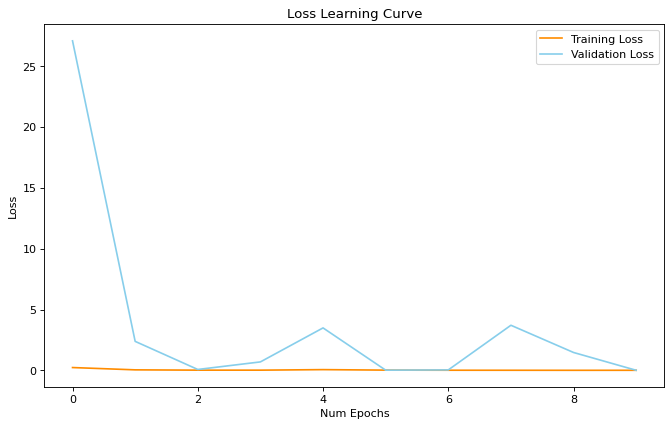

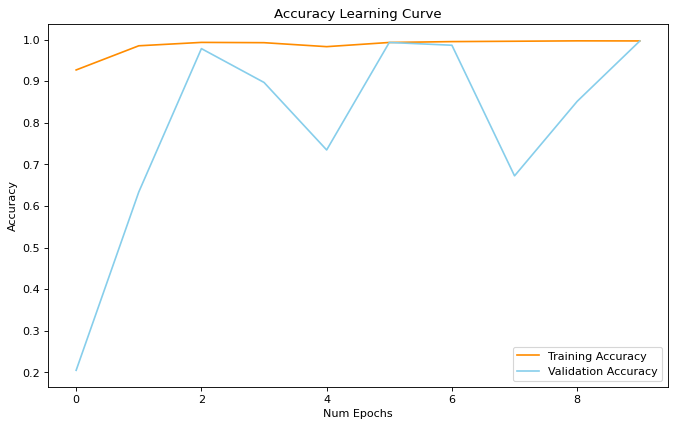

In [107]:
plot_learning(history, 'loss', 'val_loss', xtitle='Num Epochs', ytitle='Loss', plot_title='Loss Learning Curve', label_1='Training Loss', label_2='Validation Loss')
plot_learning(history, 'acc', 'val_acc', 'Num Epochs', 'Accuracy', plot_title='Accuracy Learning Curve', label_1='Training Accuracy', label_2='Validation Accuracy')


In [109]:
!mkdir saved_models

model.save('saved_models/rice_model')

/bin/bash: /home/barti/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘saved_models’: File exists


INFO:tensorflow:Assets written to: saved_models/rice_model/assets


INFO:tensorflow:Assets written to: saved_models/rice_model/assets
